# (Not so) Deep Kalman: state space modeling with variational inference

If you do not have pyro or torch installed, uncomment the following line and run it

In [14]:
#!pip install pyro-ppl
#!pip install torch

In [15]:
import numpy as np 
import random
import matplotlib.pyplot as plt


import pyro
from pyro import optim
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import constraints
import pyro.distributions.transforms as Tr
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, MultiStepLR
from pyro.nn import AutoRegressiveNN, PyroModule, PyroSample, PyroParam
from pyro.distributions.transforms import AffineAutoregressive, spline_autoregressive

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.distributions import MultivariateNormal



def set_seed(seed=0):
    torch.manual_seed(seed)
    pyro.set_rng_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

### Coding the generative model

We'll use the same simulator as for Kalman Filter

In [16]:
T_sim = 10 # total time [s]
spring_constant = 10. # spring constant [N/m]
damping_coefficient = .5 # damping coefficient [kg/s]
mass = 1 # mass [kg]
noise_std = 0.5 # standard deviation of noise
dt = 0.01 # time step [s]
z0 = np.array([1., 0.]) # initial state [pos, vel]

state_mat = np.array([[1, dt], 
                      [-dt*(spring_constant/mass), 1. - dt*damping_coefficient/mass]])

def euler_step(z_t: np.ndarray) -> tuple[np.ndarray]:
    """ Euler step for a damped mass-spring system

    Args:
        z_t: State vector [pos, vel]
        dt: time step

    Returns:
        z_new: Updated state vector
        y: Noisy observation
    """
    # state update
    z_new = np.dot(state_mat, z_t)
    # noisy observation
    noise = noise_std * np.random.randn(*z_t.shape)
    y = z_t + noise
    return z_new, y, noise

### Sama data generation  as in Kalman Filter

The following code runs the state-space model 

In [17]:
# Simulate
dim_z = dim_y = 2
t = np.arange(0, T_sim, dt)
z = np.zeros((len(t) + 1, dim_z))
y = np.zeros((len(t), dim_y))
noise = np.zeros((len(t), dim_y))
z[0] = z0
for i in range(1, len(t)+1):
    z[i], y[i-1], noise[i-1] = euler_step(z[i-1])
z = z[:-1]

### Prepare the data to be used in torch 

In [18]:
T = z.shape[0] #number of simulated observations 
z_true = torch.tensor(z).float()
data  = torch.tensor(y).float()  


### Main model with RNN between y and z to mimic smoothing, and MLP decoder from y to z

In [6]:
class NNKVAE(PyroModule):
    def __init__(self, dim_z, dim_y, T, hidden_dim=16):
        super().__init__()
        self.dim_z = dim_z
        self.dim_y = dim_y
        self.T = T 

        # Kalman parameters
        self.A = PyroParam(0.9 * torch.eye(dim_z), constraint=constraints.real)
        self.Q = PyroParam(0.05 * torch.eye(dim_z), constraint=constraints.positive_definite)
        self.Q0 = PyroParam(0.05 * torch.eye(dim_z), constraint=constraints.positive_definite)
        self.H = PyroParam(0.05 * torch.eye(dim_y), constraint=constraints.positive_definite)

        # KVAE-style nonlinear decoder instead of C @ z_t
        self.decoder = PyroModule[nn.Sequential](
            nn.Linear(dim_z, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim_y)
        )
 
        self.encoder = PyroModule[nn.GRU](
            input_size=dim_y,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.encoder_out = PyroModule[nn.Linear](2 * hidden_dim, 2 * dim_z)

    def model(self, y=None):
        z_prev = pyro.sample("z_0", dist.MultivariateNormal(torch.zeros(self.dim_z), self.Q0))

        for t in range(self.T):
            mean_z = torch.clamp(self.A @ z_prev, -10.0, 10.0)
            z_t = pyro.sample(f"z_{t+1}", dist.MultivariateNormal(mean_z, self.Q))

            mean_y = self.decoder(z_t)
            mean_y = torch.nan_to_num(mean_y, nan=0.0, posinf=10.0, neginf=-10.0)
            mean_y = torch.clamp(mean_y, -10.0, 10.0)

            obs_dist = dist.MultivariateNormal(mean_y, self.H)

            obs = y[t] if y is not None else None
            pyro.sample(f"y_{t+1}", obs_dist, obs=obs)
            z_prev = z_t

    def guide(self, y): 
        y_seq = y.unsqueeze(0)                 
        rnn_out, _ = self.encoder(y_seq)      
        enc_out_t = self.encoder_out(rnn_out.squeeze(0))  
     
        extra_row = enc_out_t.new_zeros((1, enc_out_t.size(-1)))   
        enc_out = torch.cat([extra_row, enc_out_t], dim=0)       
    
        locs, scale_diags = torch.chunk(enc_out, 2, dim=-1)
        scale_diags = scale_diags**2+1e-3
    
        # Sample  z_0..z_T
        pyro.sample("z_0", dist.MultivariateNormal(
            locs[0], scale_tril=torch.diag_embed(scale_diags[0])
        ))
        for t in range(1, self.T + 1):
            pyro.sample(
                f"z_{t}",
                dist.MultivariateNormal(locs[t], scale_tril=torch.diag_embed(scale_diags[t]))
            )

### The functions to infer the latent variables and reconstruct the observed ones and to plot them

In [7]:
def infer_latents_and_reconstruct(model, y_obs):
    with pyro.poutine.trace() as guide_trace:
        model.guide(y_obs)

    # Reconstruct without conditioning on observations
    model_sample = poutine.replay(model.model, trace=guide_trace.trace)
    sampled_trace = poutine.trace(model_sample).get_trace(None)  # or dummy y_obs if needed

    zs, ys = [], []
    for t in range(model.T):
        z_t = guide_trace.trace.nodes[f"z_{t+1}"]["value"].detach()
        y_t = sampled_trace.nodes[f"y_{t+1}"]["value"].detach()
        zs.append(z_t)
        ys.append(y_t)

    return torch.stack(zs), torch.stack(ys)
 

def plot_latent_and_observed(z, y):
    dim_z = z.shape[1]
    dim_y = y.shape[1]

    plt.figure(figsize=(12, 5))

    for i in range(dim_z):
        plt.subplot(2, dim_z, i+1)
        plt.plot(z[:, i], label=f'z[{i}]')
        plt.title(f"Latent z[{i}]")
        plt.grid(True)
        plt.legend()

    for i in range(dim_y):
        plt.subplot(2, dim_y, dim_z + i + 1)
        plt.plot(y[:, i], label=f'y[{i}]')
        plt.title(f"Observed y[{i}]")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

def plot_results(latent_model,data):
    z_inferred, y_recon = infer_latents_and_reconstruct(latent_model,data) 
    c = ["k", "green"]  
    
    # Plot ELBO loss ----
    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.title("ELBO Loss over Training");plt.xlabel("Step");plt.ylabel("ELBO")
    plt.grid(True);plt.tight_layout()
    plt.yscale("log")
    plt.show()
    
    
    # True vs Inferred Latents ----
    plt.figure(figsize=(10, 4))
    for i in range(dim_z):
        plt.subplot(1, dim_z, i+1)
        plt.plot(z_inferred[:, i], "--", label="inferred z", color = c[0], alpha=0.8, linewidth=2)
        plt.plot(z_true[:, i], color = c[1], label="true z", alpha=0.4, linewidth=2)
        plt.title(f"Latent dim {i+1}");plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # y_t from inferred z_t ---- 
    
    plt.figure(figsize=(10, 4))
    for i in range(dim_y):
        plt.subplot(1, dim_y, i+1)
        
        plt.plot(y_recon[:, i], "--", color = c[0], alpha=0.8, label="reconstructed y", linewidth=2)
        plt.plot(data[:, i], label="observed y", alpha=0.4, color = c[1], linewidth=2)
        plt.title(f"Output dim {i+1}")
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()



### Optimizing the models

In [8]:
#number of steps of Variational Inference
num_steps = 1000
initial_learning_rate = 0.1
scheduler_params =  {
	"optimizer": torch.optim.Adam,
	"optim_args": {"lr": initial_learning_rate},
	"T_0": 20, "T_mult":1,
	"eta_min": 1e-4
    }

## Train and run the NN filtering model, $q(z_t | y_t)$ on the Gaussian data

In [9]:

scheduler = optim.CosineAnnealingWarmRestarts(scheduler_params)
 

latent_model = NNKVAE(dim_z, dim_y, T)

svi = SVI(latent_model.model, latent_model.guide, scheduler, loss=Trace_ELBO()) 
# Run inference with scheduler
losses = []  
for step in range(num_steps):
    loss = svi.step(data)
    losses.append(loss)
    scheduler.step(step)
    if step % 10 == 0: 
        optimizer = list(scheduler.optim_objs.values())[0] 
        lr = optimizer.optimizer.param_groups[0]["lr"] 
        print(f"Step {step}, Loss: {loss:.2f}, LR: {lr:.2f}")



Step 0, Loss: 23263.13, LR: 0.10
Step 10, Loss: 11424.81, LR: 0.05
Step 20, Loss: 10068.05, LR: 0.10
Step 30, Loss: 8866.59, LR: 0.05
Step 40, Loss: 8467.26, LR: 0.10
Step 50, Loss: 8401.22, LR: 0.05
Step 60, Loss: 8249.06, LR: 0.10
Step 70, Loss: 8168.10, LR: 0.05
Step 80, Loss: 8142.50, LR: 0.10
Step 90, Loss: 8150.68, LR: 0.05
Step 100, Loss: 8104.56, LR: 0.10
Step 110, Loss: 8097.16, LR: 0.05
Step 120, Loss: 8050.36, LR: 0.10
Step 130, Loss: 8025.08, LR: 0.05
Step 140, Loss: 8058.90, LR: 0.10
Step 150, Loss: 8052.04, LR: 0.05
Step 160, Loss: 7980.02, LR: 0.10
Step 170, Loss: 8036.50, LR: 0.05
Step 180, Loss: 8012.21, LR: 0.10
Step 190, Loss: 8008.76, LR: 0.05
Step 200, Loss: 8012.18, LR: 0.10
Step 210, Loss: 8120.50, LR: 0.05
Step 220, Loss: 8011.18, LR: 0.10
Step 230, Loss: 7999.39, LR: 0.05
Step 240, Loss: 7946.66, LR: 0.10
Step 250, Loss: 8053.83, LR: 0.05
Step 260, Loss: 7953.03, LR: 0.10
Step 270, Loss: 8036.76, LR: 0.05
Step 280, Loss: 7948.16, LR: 0.10
Step 290, Loss: 7986.1

### Results

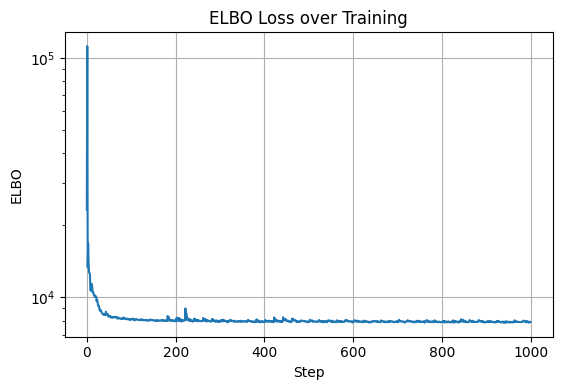

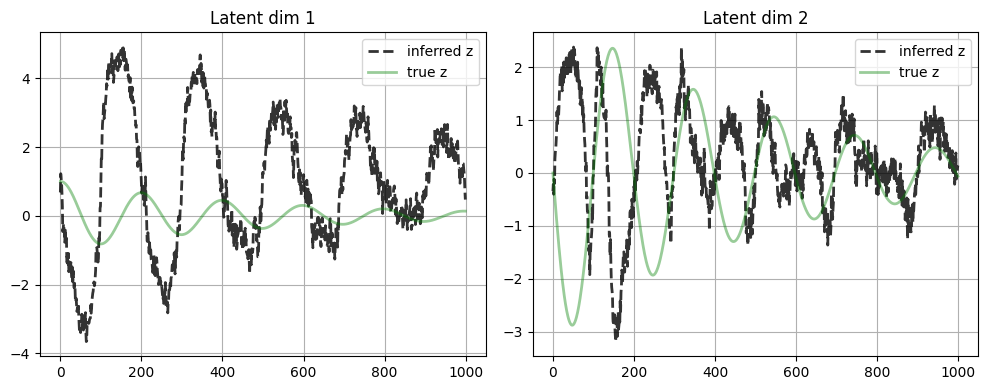

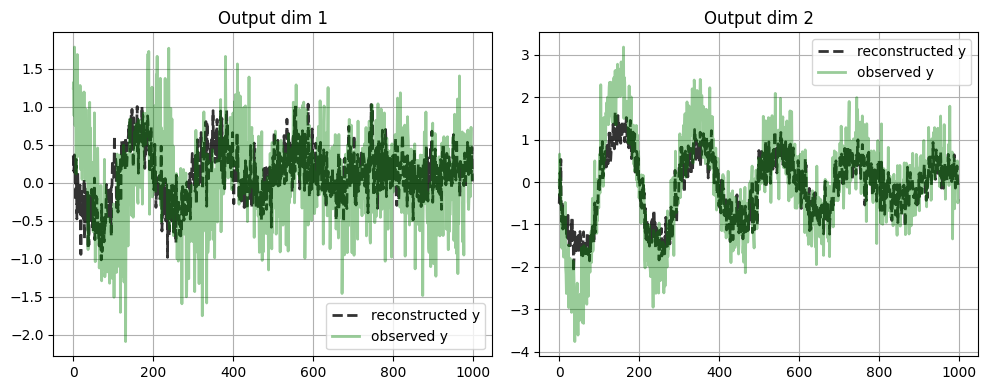

In [10]:

plot_results(latent_model,data) 

In [11]:
import pyro.distributions as dist

import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

def predict_future_with_median(latent_model, y_obs, forecast_steps=5, num_samples=100, ci=0.90):
    """
    Predict future observations with confidence intervals, returning the median trajectory
    and the model's reconstruction (rather than the exact observed data).

    Args:
        latent_model: Trained model with .guide (inferred latents), .model (defines transitions, etc.)
                      Must have .A, .Q, and .decoder for transitions/emissions.
        y_obs (Tensor): Observed data, shape [T, dim_y].
        forecast_steps (int): Number of future steps to predict.
        num_samples (int): Monte Carlo samples for uncertainty estimates.
        ci (float): Confidence interval level (e.g. 0.90 = 90%).

    Returns:
        z_inferred:        [T, dim_z] posterior means of latent states from guide (or samples used).
        y_recon:           [T, dim_y] model's predicted means (reconstruction), not pinned obs.
        y_forecast_median: [forecast_steps, dim_y] median of forecast distribution
        y_forecast_ci:     [forecast_steps, 2, dim_y], the lower & upper quantiles for forecasting
    """
    # 1. Run the guide to infer latent distribution given y_obs.
    with poutine.trace() as guide_trace:
        latent_model.guide(y_obs)

    # 2. Replay the model using that latent posterior (so we see the model's predictions).
    model_trace = poutine.trace(
        poutine.replay(latent_model.model, trace=guide_trace.trace)
    ).get_trace(y_obs)

    T = y_obs.shape[0]
    dim_y = y_obs.shape[1]

    # Extract the inferred latents from the model trace (these match the guide's samples):
    z_inferred = torch.stack([
        model_trace.nodes[f"z_{t+1}"]["value"].detach()  # shape (dim_z,)
        for t in range(T)
    ])

    # Instead of reading ["value"] (which is pinned to real obs), get the distribution's mean:
    # Here we assume a MultivariateNormal; if you use a flow transform, adapt accordingly.
    y_recon = torch.stack([
        model_trace.nodes[f"y_{t+1}"]["fn"].loc.detach()  # shape (dim_y,)
        for t in range(T)
    ])

    # 3. Get posterior distribution over z_T from the guide trace.
    z_T_node = guide_trace.trace.nodes[f"z_{T}"]
    z_T_dist = z_T_node["fn"]  # Typically a pyro.dist.MultivariateNormal

    # 4. Monte Carlo forecast forward from z_T
    forecast_samples = []
    for _ in range(num_samples):
        # Sample a final latent from q(z_T | y_obs).
        z_t = z_T_dist.sample()
        y_seq = []

        # Roll forward for 'forecast_steps' steps
        for _ in range(forecast_steps):
            # Next latent state from the linear-Gaussian transition
            mean_z = latent_model.A @ z_t
            z_t = dist.MultivariateNormal(mean_z, latent_model.Q).sample()

            # Emission from the decoder -> y_mean, then sample an observation
            y_mean = latent_model.decoder(z_t)
            # If you have a flow transform, wrap it in a TransformedDistribution
            # For now, assume a standard MvN:
            y_t = dist.MultivariateNormal(y_mean, latent_model.H).sample()

            y_seq.append(y_t)

        forecast_samples.append(torch.stack(y_seq))  # shape [forecast_steps, dim_y]

    # 5. Aggregate the forecast samples -> median & confidence intervals
    forecast_tensor = torch.stack(forecast_samples)   # [num_samples, forecast_steps, dim_y]
    y_forecast_median = forecast_tensor.median(dim=0).values  # [forecast_steps, dim_y]

    alpha_lower = (1 - ci) / 2
    alpha_upper = (1 + ci) / 2
    lower = forecast_tensor.quantile(alpha_lower, dim=0)  # [forecast_steps, dim_y]
    upper = forecast_tensor.quantile(alpha_upper, dim=0)  # [forecast_steps, dim_y]
    y_forecast_ci = torch.stack([lower, upper], dim=1)    # [forecast_steps, 2, dim_y]

    return z_inferred, y_recon, y_forecast_median, y_forecast_ci

### Prediction

In [12]:
z_inferred, y_recon, y_forecast_mean, y_forecast_ci = predict_future_with_median(latent_model, data, forecast_steps=100)
 

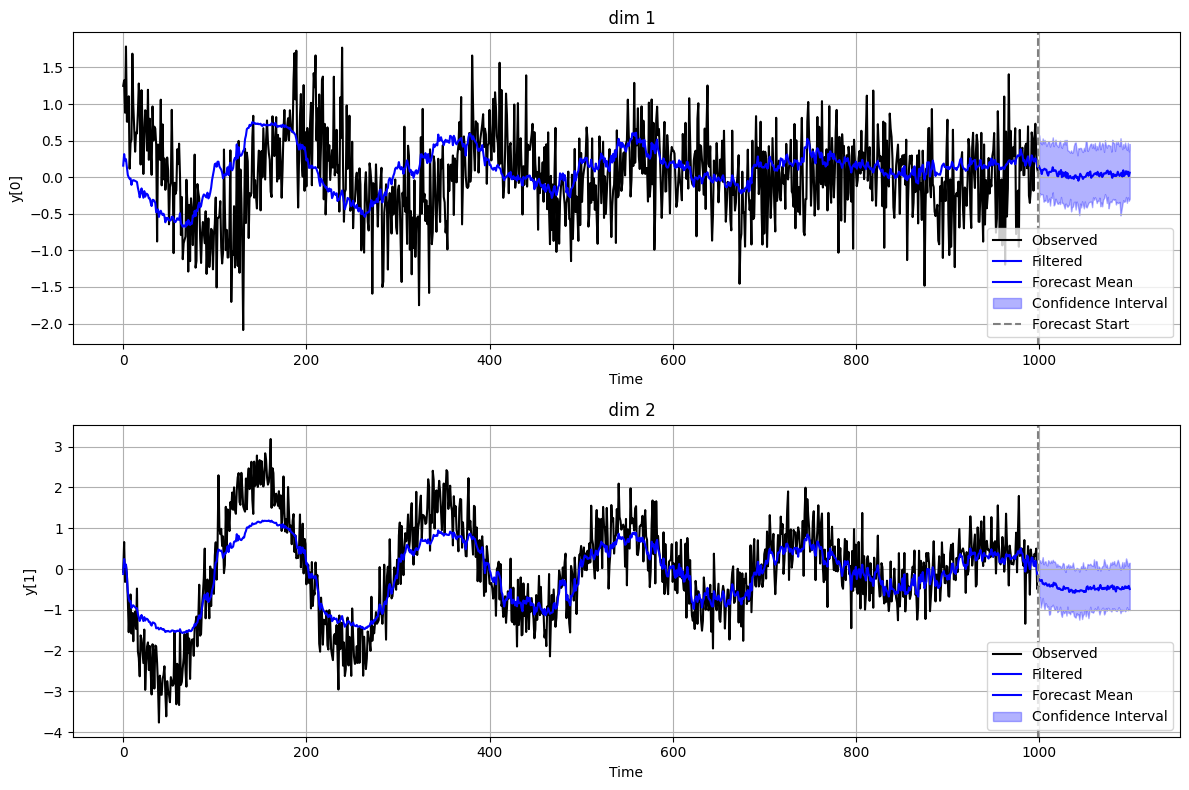

In [20]:
def plot_forecast_with_ci(y_obs, y_recon, y_forecast_mean, y_forecast_ci, title="Forecast with Confidence Intervals"):
    """
    Plot observed and forecasted data with confidence intervals.

    Args:
        y_obs (Tensor): Observed data [T, dim_y]
        y_recon : reconstructed observations 
        y_forecast_mean (Tensor): Predicted mean [forecast_steps, dim_y]
        y_forecast_ci (Tensor): Confidence intervals [forecast_steps, 2, dim_y]
    """
    y_obs = y_obs.detach().cpu()
    y_forecast_mean = y_forecast_mean.detach().cpu()
    y_forecast_ci = y_forecast_ci.detach().cpu()

    T = y_obs.shape[0]
    forecast_steps = y_forecast_mean.shape[0]
    dim_y = y_obs.shape[1]

    plt.figure(figsize=(12, 4 * dim_y))

    for i in range(dim_y):
        plt.subplot(dim_y, 1, i + 1)
        plt.plot(range(T), y_obs[:, i], label="Observed", color='black')
        
        plt.plot(range(T), y_recon[:, i], label="Filtered", color='blue')
        plt.plot(range(T, T + forecast_steps), y_forecast_mean[:, i], label="Forecast Mean", color='blue')

        # Confidence interval shading
        lower = y_forecast_ci[:, 0, i]
        upper = y_forecast_ci[:, 1, i]
        plt.fill_between(range(T, T + forecast_steps), lower, upper, color='blue', alpha=0.3, label="Confidence Interval")

        plt.axvline(T - 1, color='gray', linestyle='--', label="Forecast Start" if i == 0 else "")
        plt.xlabel("Time")
        plt.ylabel(f"y[{i}]")
        plt.title(f"{title}  dim {i+1}")
        plt.legend(); plt.grid()

    plt.tight_layout()
    plt.show()


plot_forecast_with_ci(data, y_recon, y_forecast_mean, y_forecast_ci, title="")